### Introduction to the bias-variance tradeoff

The aim of this lecture is to visually explore the concept of bias and variance in modeling and the tradeoff between the two.

Below we will be fitting models predicting student morale from the day number in the course. 


Let's assume that the Bruin gods model student morale as such according to a cubic polynomial interpolated from the following data, one data point for each week:

In [1]:
###### True measurements of morale

moralepoints = [20, 30, 35, 18, 3, 12, 35, 44, 53, 62, 73]

In [2]:
###### Define Numerical Python environment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

np.random.seed(42)

%matplotlib inline

In [3]:
###### Define vector of days

weeks = 10
days = np.arange(weeks*7+1)

#### Actual Data According to the Universe

In [4]:
###### Create tuples of weekpoints and measurements of morale

weekpoints = 7*np.arange(weeks+1)

list(zip(weekpoints, moralepoints))

[(0, 20),
 (7, 30),
 (14, 35),
 (21, 18),
 (28, 3),
 (35, 12),
 (42, 35),
 (49, 44),
 (56, 53),
 (63, 62),
 (70, 73)]

#### Morale function as Interpolated by the Bruin Gods

The `interp1d` function creates an interpolation function for us between the week numbers and morale points. The `kind='cubic'` parameter indicates the smoothing of the interpolation.

In [5]:
###### Build interpolation function using weekpoints and measurements of morale

morale_func = interp1d(weekpoints, moralepoints, kind='cubic')

We can plot out the "true function" of days predicting morale below:

In [6]:
###### Compute true values associated with days

morale_true = morale_func(days)

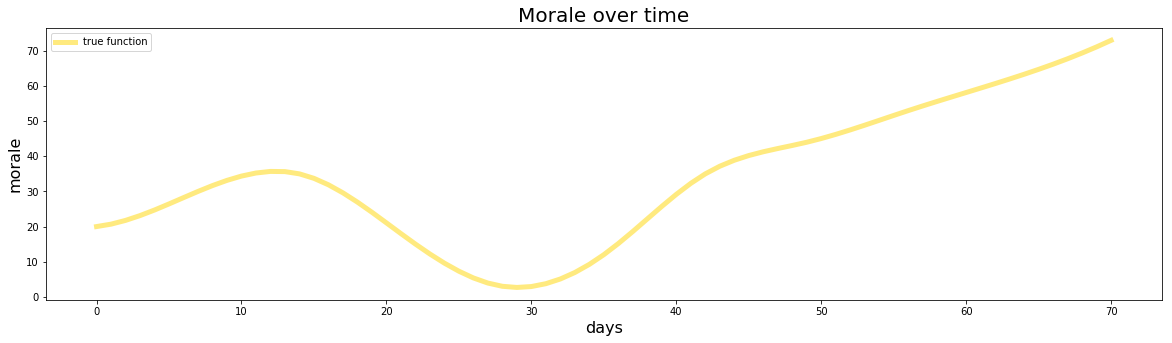

In [7]:
###### Plot true morale over the span of a course

plt.figure(figsize=(20, 5))
plt.plot(days, morale_true, linewidth=5, color='gold', alpha=0.5, label='true function')

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time', fontsize=20)

plt.legend(loc='upper left')

plt.show()

##### Important Points

1. We can never know this function.
1. We can only model this function.
1. In building a model, we will introduce error.
1. A model will have three kinds of error: $$\text{Error} = \text{Error from Bias} + \text{Error from Variance} + \text{Unknown Error}$$
1. All three of these are strictly non-negative.

**The goal when building a model is to minimize the error from bias *and* the error from variance.**

The perfect model would have zero bias and zero variance. In reality, the bias or the variance (typically) increases while the other decreases.

We can interpret this "true function" in different ways:

1. **As morale without individual variance:** the true function is the baseline morale for each time point that all students vary around to some degree. Students' morale at any given time point is this baseline morale plus or minus some individual deviation. When coding this in python, for each "student" we take the *true* measure of morale from the morale function, and then to create the individual variance we will add random noise to that starting point. 
1. **As morale without measurement error:** maybe all student morale at every timepoint is the same, it's just that our way of measuring morale is unreliable. The true function represents the morale at any timepoint for any student without measurement error. If our measurement tool was perfect (a perfect morale survey) we would measure the same morale for every student at each time point. But if the survey form is broken and randomly changes answers by students, for example, then we are adding noise to the measured morale for each observation. 
1. **As an average morale across infinite students:** our measurements of morale vary at each time point for each student, but if we had an infinite number of students and averaged all of their morale measurements across all time points, we would end up with the true function of `morale(time)`. 

**In each case, we are describing morale as a function of time without error, where each is describing a different source of error:**

1. Error resulting from an imperfect relationship between time and morale.
1. Error resulting from an imperfect ability to measure morale.
1. Error resulting from an insufficient amount of data to quantify the relationship correctly.

We will see that each of these sources of error combined make up the full error in any model we build. Respectively:

1. The **bias**.
3. The **variance**.
2. The **irreducible error**.

You will always have error in your models, it just depends how much and what proportion of each type. We will formalize these components of error in a model further down.

<a id='generate-students'></a>
## Generate a sample of students

---

Say we have four students: student A, B, C, and D.

Each student has had their morale checked 12 different times throughout the course, but not necessarily at the same times.

**Below is a function that will generate the days and morale for each student as a dictionary object.**

*Note: here we are using the morale function to get the true morale for a given day, then adding the individual variance and/or measurement error from a normal distribution.*

In [8]:
###### Define a dictionary of measured morale for four students

students = {}
for student in ['A','B','C','D']:
    daysamp = np.random.choice(days, replace=False, size=12)
    morales = morale_func(daysamp) + np.random.normal(0,13, size=12)
    students[student] = {'days':daysamp, 'morale':morales}

#### Student A's morale over time

Below we can plot student A's morale at each day. The true function is also plotted in yellow.

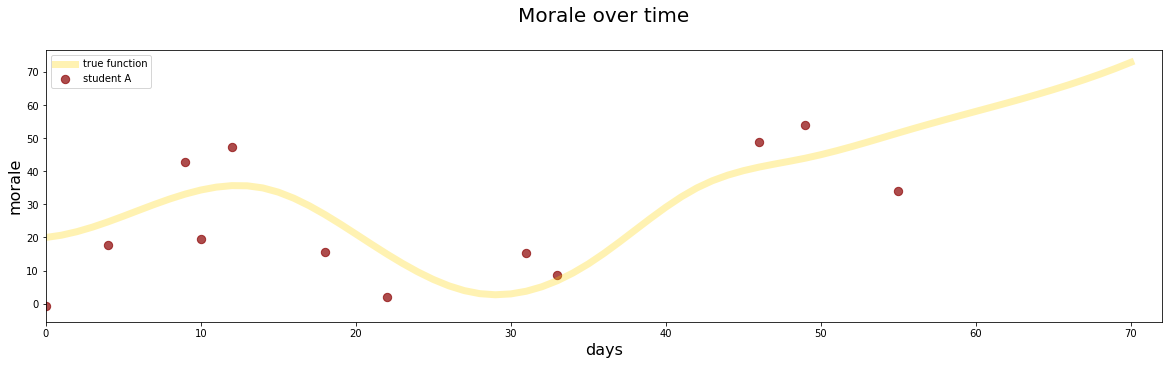

In [9]:
###### Plot Measured Values for Student A versus True Morale 

plt.figure(figsize=(20, 5))
plt.plot(days, morale_true, lw=7., c='gold', alpha=0.3, label='true function')
plt.scatter(students['A']['days'], students['A']['morale'],
            s=70, c='darkred', label='student A', alpha=0.7)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')
plt.show()

#### Build a model for days predicting morale using student A's data

With this student's data, I decide to model the relationship between days and morale with a linear regression.

My model is:

$$\hat{morale} = \beta_0 + \beta_1days$$

**Construct the model:**

In [10]:
###### Construct a Linear Regression model for Student A

studA_days = students['A']['days']
studA_mor = students['A']['morale']

Amod = LinearRegression()
Amod.fit(studA_days[:, np.newaxis], studA_mor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

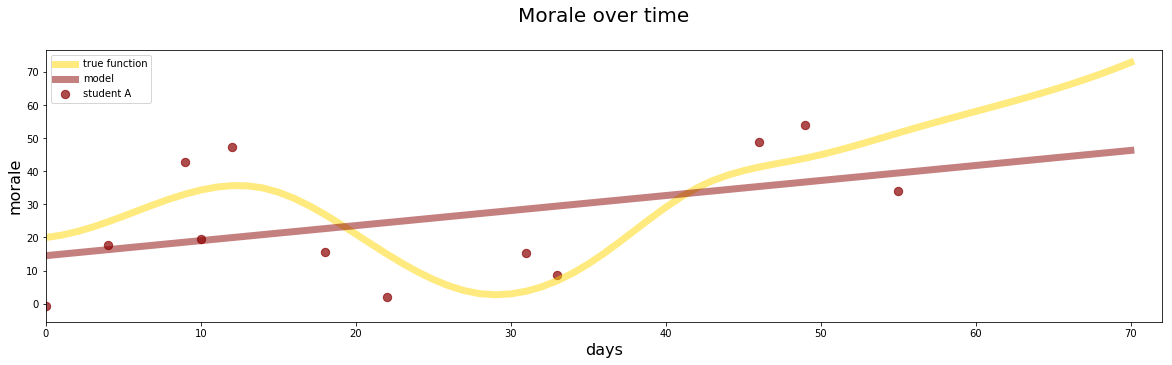

In [11]:
###### Plot the modeled relationship between days and morale

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

plt.plot(days, Amod.predict(days[:, np.newaxis]), lw=7., c='darkred', alpha=0.5, label='model')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')

#### The total error of a model

As you can see above, our regression line is an imperfect representation of the true function. Furthermore, the regression model fails to perfectly capture the variance of the morale in our sample data. 

The model is our blueprint for the estimation of morale. We have chosen to estimate morale 
from simply the number of days that have elapsed in the course. In doing so, we have made an assumption: morale is a linear function of days. 

**When we talk about the bias-variance tradeoff in modeling, and the bias and variance components of error, it is important to think about this in the context of building our model on many samples of the data.** For example, we take our model parameterization `morale ~ days` and build this on the data for student A, then student B, then student C, then student D, and so on. Think of the "students" as random samples of morale and days elapsed from the overall population.

**There are three sources of error in a model:**

$$\text{Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

$$E\Big[\big(\hat{f}(x) - f(x)\big)^2\Big] = \big(\;\text{E}[\;\hat{f}(x)\;] - f(x)\;\big)^2 + \text{E}\big[\;(\;\hat{f}(x) - \text{E}[\;\hat{f}(x)\;])^2\;\big] + E\Big[\big(y - f(x)\big)^2\Big] $$

Where:

- $f(x)$ is the true function of y given the predictors.
- $\hat{f}(x)$ is the estimate of y with the model fit on a random sample of the predictors.
- $E\Big[\big(\hat{f}(x) - f(x)\big)^2\Big]$ is the average squared error across multiple models fit on different  random samples between the model and the true function.
- $\text{E}[\;\hat{f}(x)\;]$ is the average of estimates for given predictors across multiple models fit on different random samples.
- $E\Big[\big(y - f(x)\big)^2\Big]$ is the average squared error between the true values and the predictions from the true function of the predictors. This is the **irreducible error**.
- $\big(\;\text{E}[\;\hat{f}(x)\;] - f(x)\;\big)^2$ is the squared error between the average predictions across multiple models fit on different random samples and the prediction of the true function. This is the **bias** (squared).
- $\text{E}\big[\;(\;\hat{f}(x) - \text{E}[\;\hat{f}(x)\;])^2\;\big]$ is the average squared distance between individual model predictions and the average prediction of models across multiple random samples. This is the **variance**.

**The irreducible error is "noise" – error in the measurement of our target that cannot be accounted for by our predictors.**

- The true function represents the most perfect relationship between predictors and target, but that does not mean that our variables can perfectly predict the target.
- The irreducible error can be thought of as the measurement error: variation in the target that we cannot represent.

We will go into the bias and variance components individually, in more detail.

#### Bias

The $bias^2$ is the source of error in our model that represents how *oversimplified* our model is. In our example, we have built a function to predict the morale of students as a linear function of days elapsed. However, we can see from the true function that the relationship between days and morale is not a line. This error is encapsulated in the bias.

$$Bias^2 = \big(\;\text{E}[\;\hat{f}(x)\;] - f(x)\;\big)^2$$

**Remember:** we have to think about measuring the bias and variance using different fits of our model across multiple random samples! The bias represents the deviation of the *average predictions across models* from the true function.

**What does having a high vs. low bias mean?**

- If our models are consistently wrong, then the bias will be large.
- Alternatively, if our models are consistently correct then the bias will be small.
- Bias will be small if the errors across our models built on random samples and tested using the same predictors are incorrect in different directions that average out close to 0. 

Linear methods like regression tend to have a high bias because we construct a simplification of the true function.

**Below we can plot the error differences between the true function and our model built on student A's data.** 

No matter how many lines we fit on different students, those regression lines are never going to average together into the nonlinear true function! Our average estimate across models will always deviate from the true function somewhere across the days.

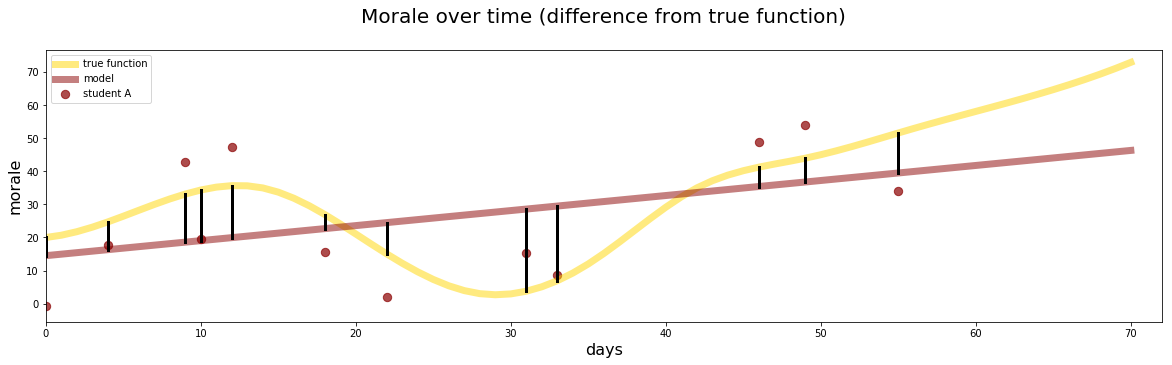

In [12]:
###### Plot Regression Model for Student A versus True Morale 

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

predictions = Amod.predict(days[:, np.newaxis])
plt.plot(days, predictions, lw=7., c='darkred', alpha=0.5, label='model')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

for d in students['A']['days']:
    p = Amod.predict(d)
    plt.plot([d, d], [p, morale_func(d)], c='black', lw=3.)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time (difference from true function)\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')


#### Variance

The second component of error in the model is the variance of our predictions. 

Variance describes the extent to which the individual predictions from models built on different samples (students) deviate from the mean of all the model predictions.

$$\text{Variance} = \text{E}\big[\;(\;\hat{f}(x) - \text{E}[\;\hat{f}(x)\;])^2\;\big]$$

##### High vs. low variance

- The variance will be large if, for the same observation, models built on different random samples of the data will produce very different predictions.
- Variance is a measure of how *consistent* our model's predictions will be if it were fit on another sample of data. 
- Variance is low if the data we train the model on has very little effect on the predictions.

Note that variance is not a measure of how correct or incorrect the predictions are. It is a measure of how variable they are!

#### Measuring more students

To better visualise the concept of model variance, lets say we measure a second student, student "B":

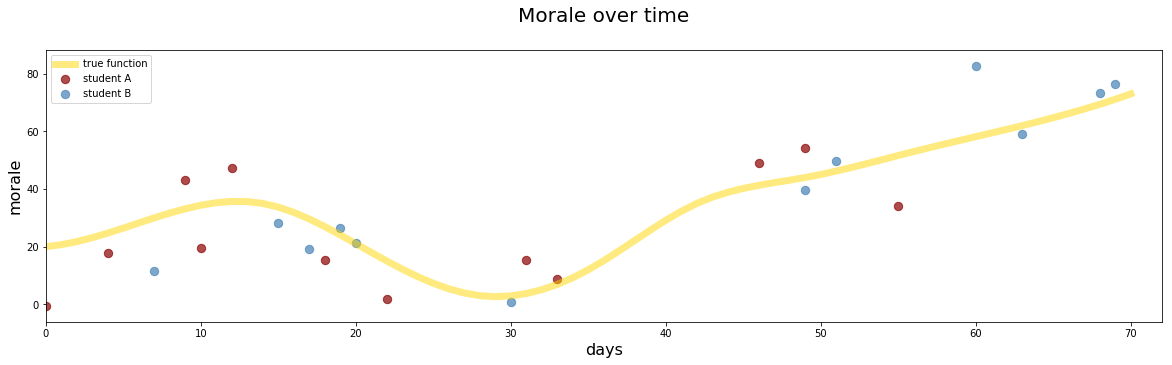

In [13]:
###### Plot Measured Values for Students A and B versus True Morale 

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

plt.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')

In [14]:
###### Fit model for Student B

studB_days = students['B']['days']
studB_mor = students['B']['morale']

Bmod = LinearRegression()
Bmod.fit(studB_days[:, np.newaxis], studB_mor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

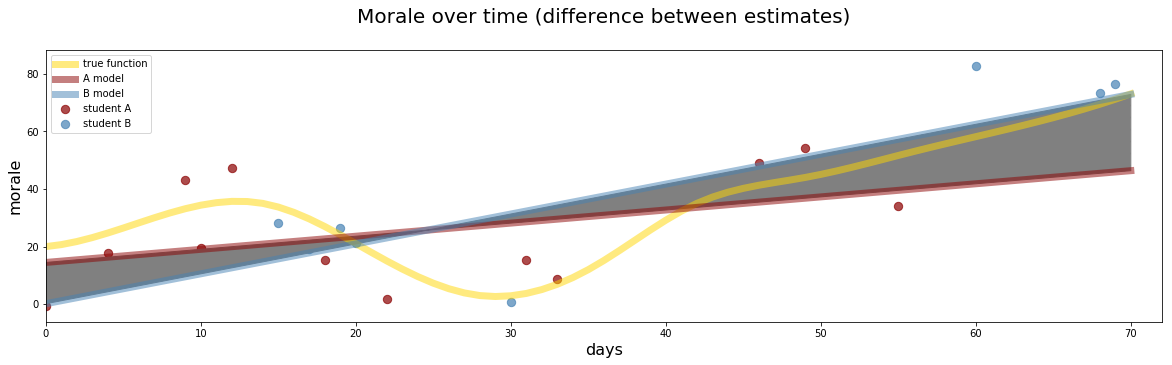

In [15]:
###### Plot Regression Models for Students A and B versus True Morale 

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

Apred = Amod.predict(days[:, np.newaxis])
plt.plot(days, Apred, lw=7., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod.predict(days[:, np.newaxis])
plt.plot(days, Bpred, lw=7., c='steelblue', alpha=0.5, label='B model')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

plt.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

plt.fill_between(days, Apred, Bpred, color='grey', hatch='//', edgecolor=None)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time (difference between estimates)\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')

#### Bias and variance using 3 models

Below we will assess the morale of 3 different students over the days in the course at different times. 

We can build these simple `morale ~ time` models for each and plot the regression lines.

These models are **high bias and low variance**. This is because there is a considerable amount of difference between the average of the model predictions and the true function, but not a lot of variation in predictions at time points across our models for the 3 students.

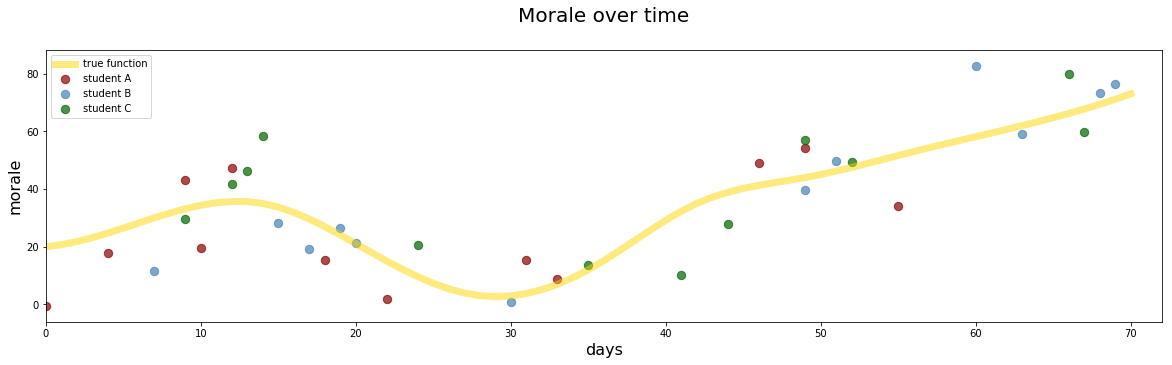

In [16]:
###### Plot Measured Values for Students A, B, and C versus True Morale 

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

plt.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

plt.scatter(students['C']['days'], students['C']['morale'],
           s=70, c='darkgreen', label='student C', alpha=0.7)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')

In [17]:
###### Fit model for Student B

studC_days = students['C']['days']
studC_mor = students['C']['morale']

Cmod = LinearRegression()
Cmod.fit(studC_days[:, np.newaxis], studC_mor)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

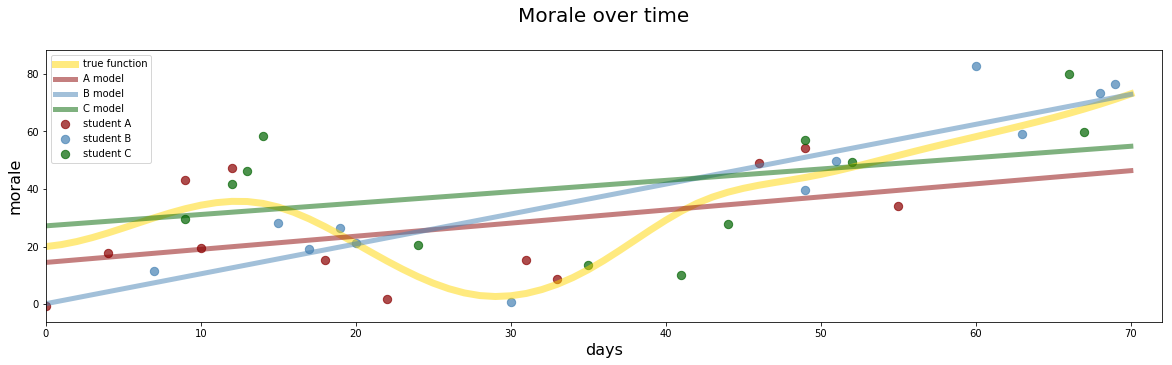

In [18]:
###### Plot Regression Models for Students A, B, and C versus True Morale 

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

Apred = Amod.predict(days[:, np.newaxis])
plt.plot(days, Apred, lw=5., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod.predict(days[:, np.newaxis])
plt.plot(days, Bpred, lw=5., c='steelblue', alpha=0.5, label='B model')

Cpred = Cmod.predict(days[:, np.newaxis])
plt.plot(days, Cpred, lw=5., c='darkgreen', alpha=0.5, label='C model')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

plt.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

plt.scatter(students['C']['days'], students['C']['morale'],
           s=70, c='darkgreen', label='student C', alpha=0.7)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time\n', fontsize=20)
plt.xlim([0, 72])

plt.legend(loc='upper left')

#### Increasing complexity to try and capture the true function

Currently our models predict that morale simply increases over time. 

Looking at the true function, we can see that there is an increase, then a decrease, and then an increase again. 

Just modeling with a linear effect of time alone can't fit a curve; there is only one coefficient being multiplied by time to make our morale prediction. We could, however, add more variables created from time such as $time^2$, $time^3$, etc.

$$\hat{morale} = \beta_0 + \beta_1 t + \beta_2 t^2$$
$$\hat{morale} = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 t^3 + \beta_4 t^4$$
$$\hat{morale} = \beta_0 + \beta_1 t + ... + \beta_{16} t^{16}$$

**The plots below show the difference in the fit when you add different numbers of "polynomial" time variables:**

In [19]:
###### Define a function to prepare a Polynomial Regression function

def polynomial_modeler(X, y, degrees):
    polynomial_features = PolynomialFeatures(degree=degrees,
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    return pipeline

In [20]:
###### Define a function to prepare a Plot of Polynomial Regressions for various powers

def plot_polyfit(X, y, truefunc, degrees=[1,2,4,16], 
                 student_color='darkred', name='A'):
    
    # set the plot size
    plt.subplots(figsize=(20,2))

    # create a plot for each polynomial degree plotted
    for i in range(len(degrees)):
        ax = plt.subplot(1, len(degrees), i + 1)
  
        poly_model = polynomial_modeler(X, y, degrees[i])

        X_test = np.linspace(1, 70, 200)
        plt.plot(X_test, poly_model.predict(X_test[:, np.newaxis]), lw=5.,
                 c=student_color, label="model", alpha=0.6)
        plt.plot(X_test, truefunc(X_test), lw=5., c='gold', alpha=0.6, label='true function')
        plt.scatter(X, y, label="Student observations", c=student_color, s=40)
        plt.xlabel("days")
        plt.ylabel("morale")
        plt.xlim((0, 72))
        plt.ylim((-20, 100))
        plt.legend(loc="best")
        
        plt.title('Student '+name+" (degree {})".format(degrees[i]))
        

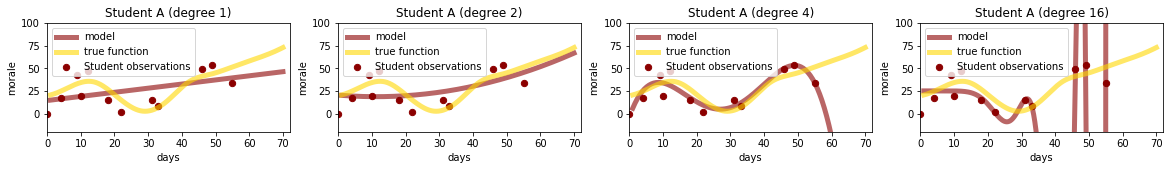

In [21]:
###### Run the Polynomial Plot for Student A

plot_polyfit(students['A']['days'], students['A']['morale'], morale_func,
             student_color='darkred', name='A')

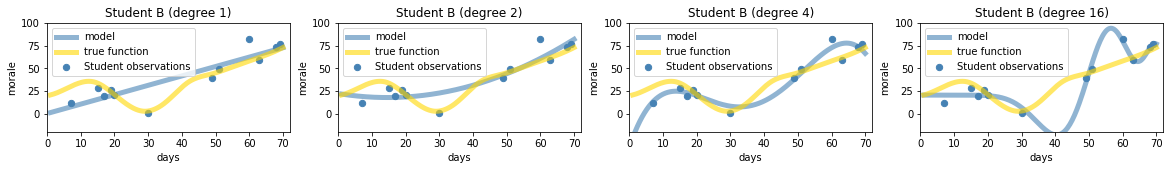

In [22]:
###### Run the Polynomial Plot for Student B

plot_polyfit(students['B']['days'], students['B']['morale'], morale_func,
             student_color='steelblue', name='B')

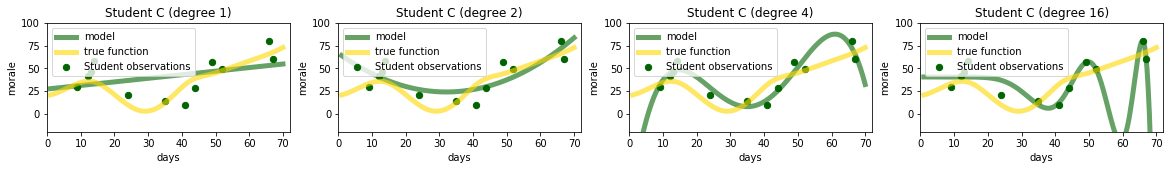

In [23]:
###### Run the Polynomial Plot for Student C

plot_polyfit(students['C']['days'], students['C']['morale'], morale_func,
             student_color='darkgreen', name='C')

#### Higher complexity means higher variance (and lower bias)

The variance of predictions across our models goes up as we increase the model complexity. This is equivalent to saying that the variance of our model is increasing.

Increasing the complexity of the model at the expense of good future predictions is known as "overfitting" the data. High variance and overfitting are intrinsically related: if your predictions are inconsistent across samples, you are more likely to make the wrong predictions on future data.

Likewise, high bias and underfitting are related. If your model is too basic, it may give very consistent predictions but at the cost of oversimplifying the relationship between the target and predictors.

**Below are student A and student B fit with the 16-polynomial time model and the area showing the difference in predictions at time points between them.** Compare this to the area we saw earlier with the single time term.

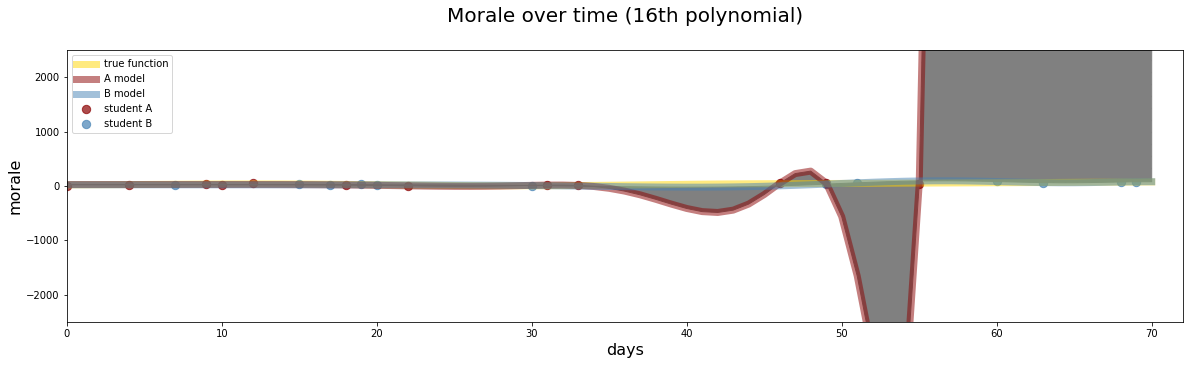

In [24]:
###### Plot $16^{th}$-order Regression Models for Students A and B versus True Morale 

plt.figure(figsize=(20, 5))

plt.plot(days, morale_true, lw=7., c='gold', alpha=0.5, label='true function')

Amod_complex = polynomial_modeler(students['A']['days'], students['A']['morale'], 16)
Bmod_complex = polynomial_modeler(students['B']['days'], students['B']['morale'], 16)


Apred = Amod_complex.predict(days[:, np.newaxis])
plt.plot(days, Apred, lw=7., c='darkred', alpha=0.5, label='A model')

Bpred = Bmod_complex.predict(days[:, np.newaxis])
plt.plot(days, Bpred, lw=7., c='steelblue', alpha=0.5, label='B model')

plt.scatter(students['A']['days'], students['A']['morale'],
           s=70, c='darkred', label='student A', alpha=0.7)

plt.scatter(students['B']['days'], students['B']['morale'],
           s=70, c='steelblue', label='student B', alpha=0.7)

plt.fill_between(days, Apred, Bpred, color='grey', hatch='//', edgecolor=None)

plt.xlabel('days', fontsize=16)
plt.ylabel('morale', fontsize=16)
plt.title('Morale over time (16th polynomial)\n', fontsize=20)
plt.xlim([0, 72])
plt.ylim([-2500,2500])

plt.legend(loc='upper left')

<include type="image" url="bv-tradeoff.png">

###### Illustrating the Bias-Variance Tradeoff

![](../img/bv-tradeoff.png)
    
</include>

#### An Illustrative Example: Voting Intentions

Imagine we conduct a phone poll to see how voters in a town will vote in the next election and get these results:

| Voting Republican	| Voting Democratic	| Non-Respondent | 	Total |
|:-----------------:|:-----------------:|:--------------:|:------:|
|                13	|                16	|              21|     50 |

In [25]:
###### Create Poll Simulation

poll_results = {'voting_republican': 13,
                'voting_democratic': 16,
                'non-respondent': 21}
total = sum([val for key,val in poll_results.items()])
total_voting = sum([val for key,val in poll_results.items()
                    if key != 'non-respondent'])

In [26]:
###### Probability of Voting Republican According to Poll

probability_of_voting_R = poll_results['voting_republican']/float(total_voting)
probability_of_voting_R

0.4482758620689655

We put out our press release that the Democrats are going to win by over 10 points; but, when the election comes around, it turns out they actually lose by 10 points. 